In [1]:
import glob
import os
import shutil
!pip install deepspeed
import deepspeed as ds
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from pytorch_lightning.utilities import CombinedLoader
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image
import cv2

_ = L.seed_everything(0, workers=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.3 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.14.4-py3-none-any.whl size=1445512 sha256=3a2e7be090d2ea581b8796dc6a2112f9fe0fc9d38482c3845b7e93408314466b
  Stored in directory: /root/.cache/pip/wheels/8e/bc/a3/608e90bbb301848b78fd75d24d6d43ba3074de968fc0e397ac
Successfully built deepspeed
[2024-07-08 16:29:47,454] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.1
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


<div class="anchor" id="top" style=" margin-right: auto; margin-left: auto; padding: 10px; font-size : 15px; background-color: #DFFFFE; border-radius: 2px; font-color :  #581845  ; border: 2px solid #581845;"> I’m Something of a Painter Myself: Use GANs to create art <b>This is a typical style shift problem.</b>


Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. 


A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.


The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.


Our task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 15px;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
 
- [1. Dataset Description](#1)
- [2. Exploratory Data Analysis](#3)
    - [2.1 Color Channel Histograms](#2.1)
    - [2.2 Individual Channels Visualization](#2.2)
    - [2.3 Grayscale Visualization](#23-grayscale-visualization)
- [3. DModel Architecture](#3)
    - [3.1 Downsampling blocks](#3.1)
    - [3.2 ResNet generator](#3.2)
    - [3.3 U-Net Generator](#33-u-net-generator)
    - [3.4 CycleGAN](#34-cyclegan)
- [4. Results and Analysis](#4)
- [5. Conclusion](#5)

# <a id="1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Dataset Description </p>   </span></font></center> 

# 1. Dataset Description

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
    
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The monet_tfrec and `monet_jpg` directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The `monet` directories contain Monet paintings. Use these images to train your model.

The `photo` directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.


**Files**
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format
    
Data Source By: 
- Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

In [2]:
monet_sz = len(os.listdir('/kaggle/input/gan-getting-started/monet_jpg'))
photo_sz = len(os.listdir('/kaggle/input/gan-getting-started/photo_jpg'))
print(f'The size of monet images is: {monet_sz}')
print(f'The size of origin images is: {photo_sz}')


The size of monet images is: 300
The size of origin images is: 7038


In [3]:
def show_img(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(10, 7))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [4]:
class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform_train = T.Compose([
            T.Resize((load_dim, load_dim), antialias=True),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2,
                          saturation=0.2, hue=0.1),
        ])
        self.transform = T.Resize((target_dim, target_dim), antialias=True)   
    def __call__(self, img, stage):
        if stage == "fit":
            img = self.transform_train(img)
        else:
            img = self.transform(img)
        return img * 2 - 1

In [5]:
class CustomDataset(Dataset):
    def __init__(self, filenames, transform, stage):
        self.filenames = filenames
        self.transform = transform
        self.stage = stage
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img = read_image(img_name) / 255.0
        return self.transform(img, stage=self.stage)

In [6]:
DEBUG = False

DM_CONFIG = {    
    "monet_dir": os.path.join("/kaggle/input/gan-getting-started/monet_jpg", "*.jpg"),
    "photo_dir": os.path.join("/kaggle/input/gan-getting-started/photo_jpg", "*.jpg"),
    
    "loader_config": {
        "num_workers": os.cpu_count(),
        "pin_memory": torch.cuda.is_available(),
    },
    "sample_size": 5,
    "batch_size": 32 if not DEBUG else 1,
}

In [7]:
class CustomDataModule(L.LightningDataModule):
    def __init__(
        self,
        monet_dir,
        photo_dir, 
        loader_config,
        sample_size,
        batch_size,
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size       
            
        # store file paths 
        self.monet_filenames = sorted(glob.glob(monet_dir))
        self.photo_filenames = sorted(glob.glob(photo_dir))
        
        # define transformations for image augmentation
        self.transform = CustomTransform()
        
    def setup(self, stage):
        if stage == "fit":
            self.train_monet = CustomDataset(self.monet_filenames, self.transform, stage)
            self.train_photo = CustomDataset(self.photo_filenames, self.transform, stage)
            
        if stage in ["fit", "test", "predict"]:
            # to be used for test and prediction datasets as well
            self.valid_photo = CustomDataset(self.photo_filenames, self.transform, None)
            
    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": True,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_monet = DataLoader(self.train_monet, **loader_config)
        loader_photo = DataLoader(self.train_photo, **loader_config)
        loaders = {"monet": loader_monet, "photo": loader_photo}
        return CombinedLoader(loaders, mode="max_size_cycle")
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_photo,
            batch_size=self.sample_size,
            **self.loader_config,
        )
    
    def test_dataloader(self):
        return self.val_dataloader()
    
    def predict_dataloader(self):
        return DataLoader(
            self.valid_photo,
            batch_size=self.batch_size,
            **self.loader_config,
        )

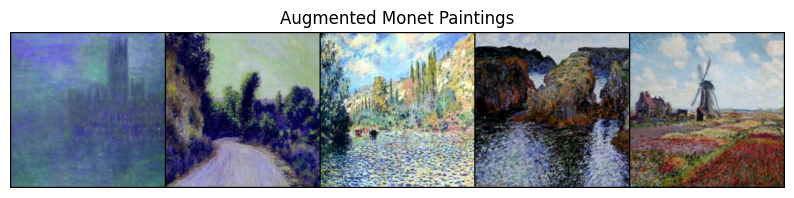

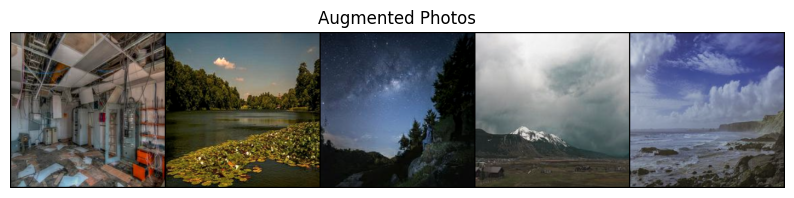

In [8]:
dm_sample = CustomDataModule(batch_size=5, **{k: v for k, v in DM_CONFIG.items() if k != "batch_size"})
dm_sample.setup("fit")
train_loader = dm_sample.train_dataloader()
imgs = next(iter(train_loader))
show_img(imgs[0]["monet"], nrow=5, title="Augmented Monet Paintings")
show_img(imgs[0]["photo"], nrow=5, title="Augmented Photos")

# <a id="2"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Exploratory Data Analysis </p>   </span></font></center> 
# 2. Exploratory Data Analysis

## 2.1 Color Channel Histograms
# <a id="2.1"></a>

In [9]:
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        # plt.xticks([])
        # plt.yticks([])
    
    
    plt.show()

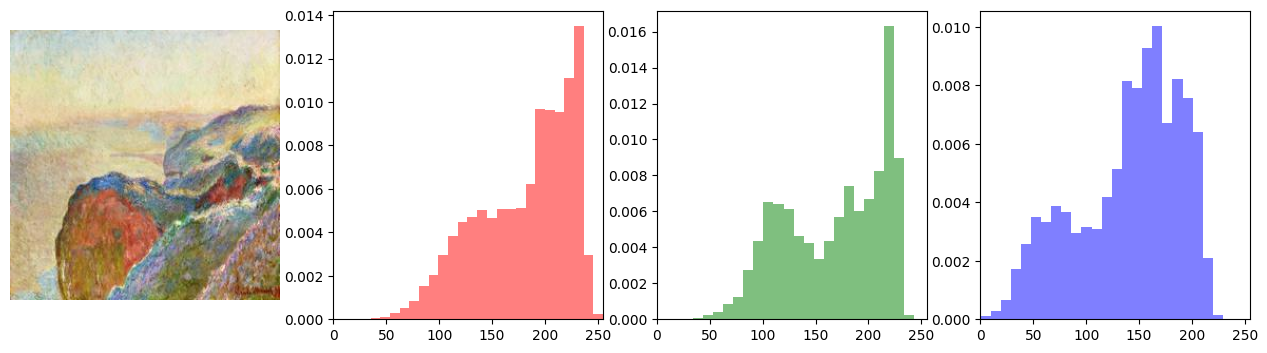

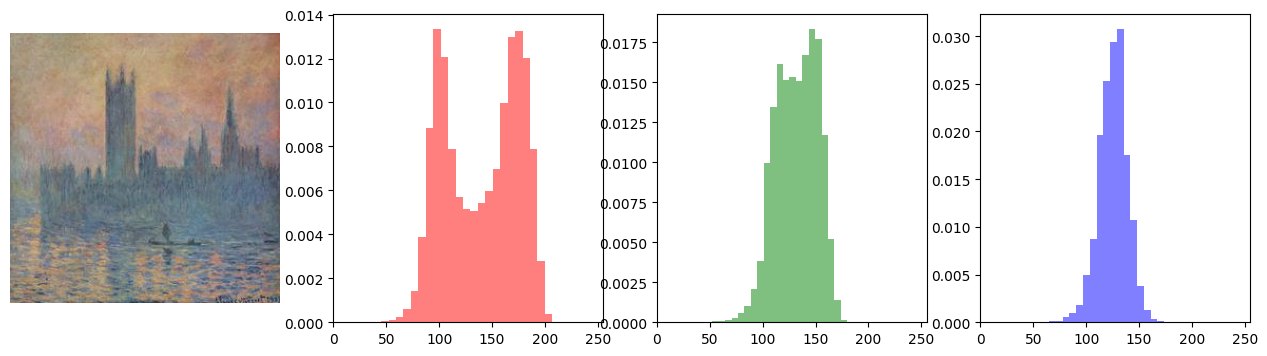

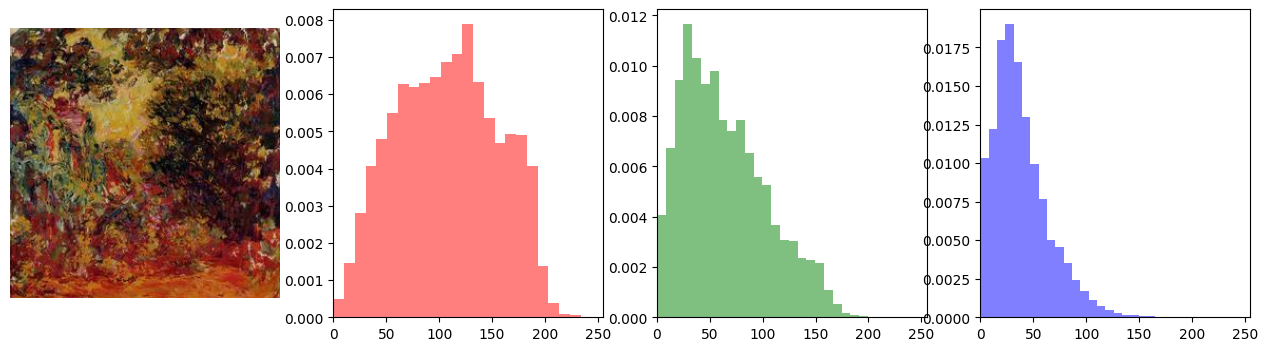

In [10]:
img_path = '/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg'
color_hist_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/05144e306f.jpg'
color_hist_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/16dabe418c.jpg'
color_hist_visualization(img_path)

## 2.2 Individual Channels Visualization
# <a id="2.2"></a>

In [11]:
def channels_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(np.mean(img, axis=2), cmap="gray")
    plt.axis('off')
    
    for i in range(3):
        plt.subplot(1, 4, i + 2)
        tmp_img = np.full_like(img, 0)
        tmp_img[:, :, i] = img[:, :, i]
        plt.imshow(tmp_img)
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    
    
    plt.show()

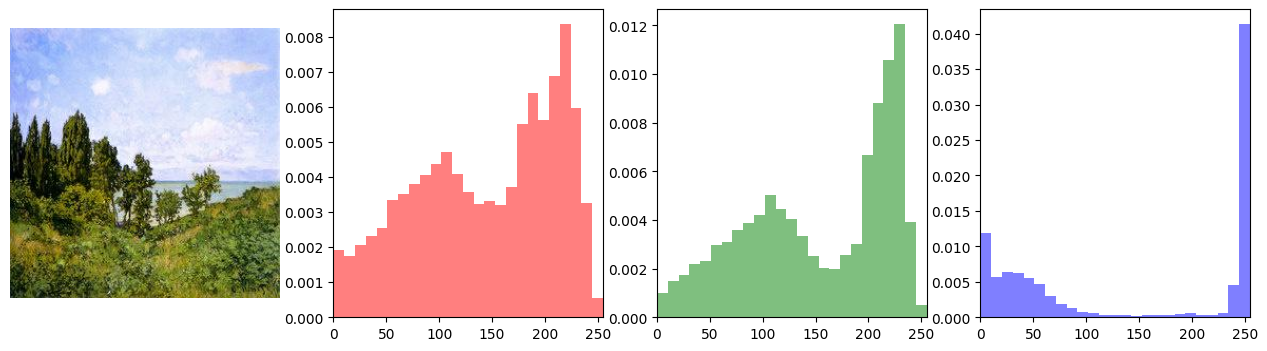

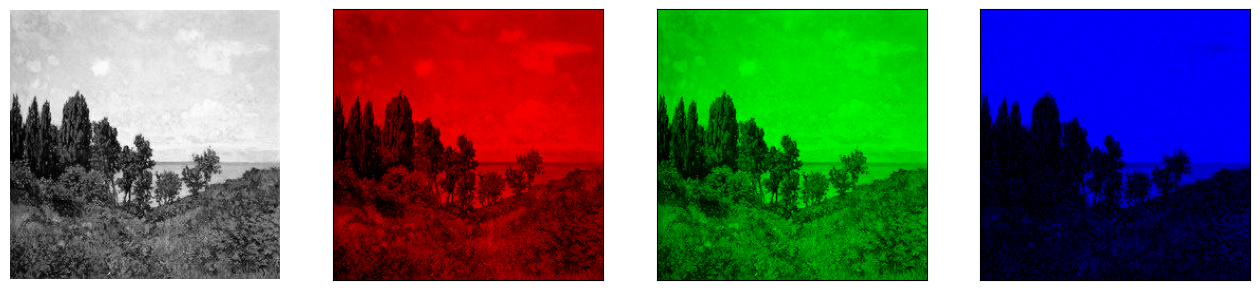

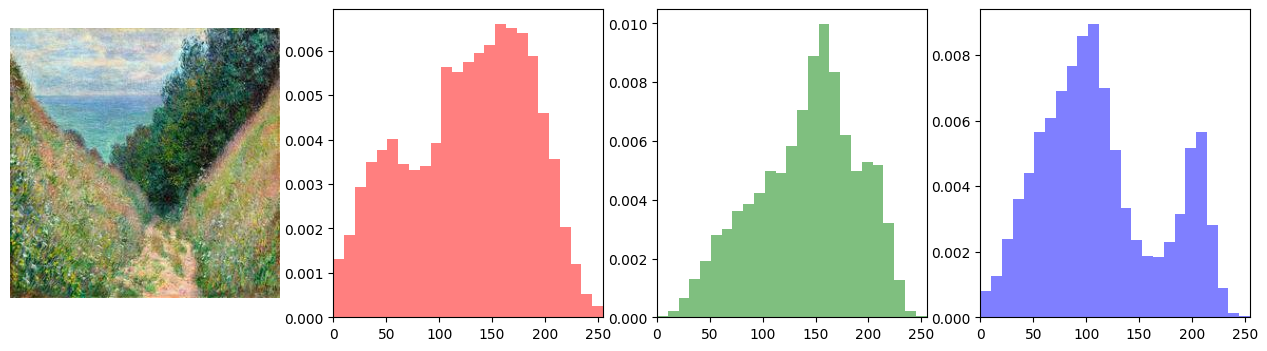

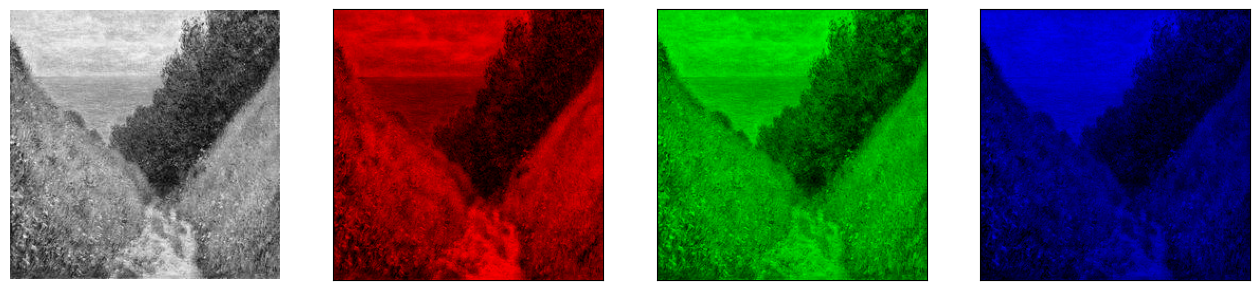

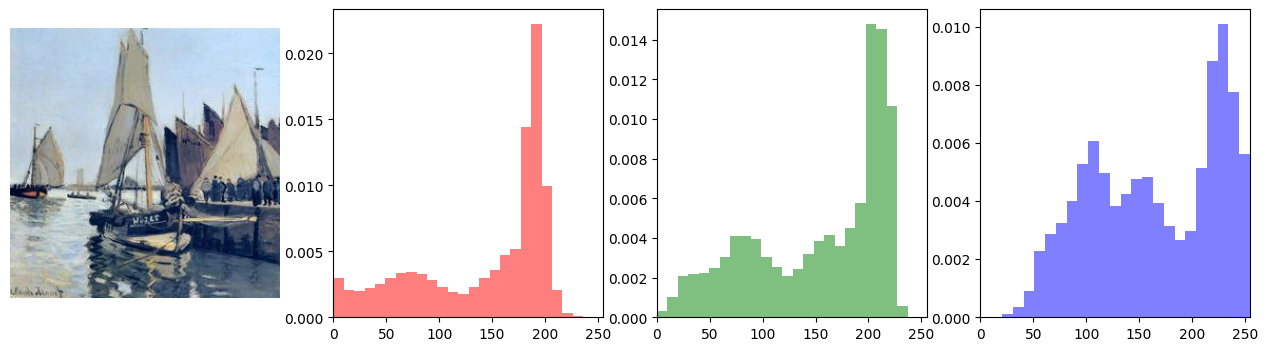

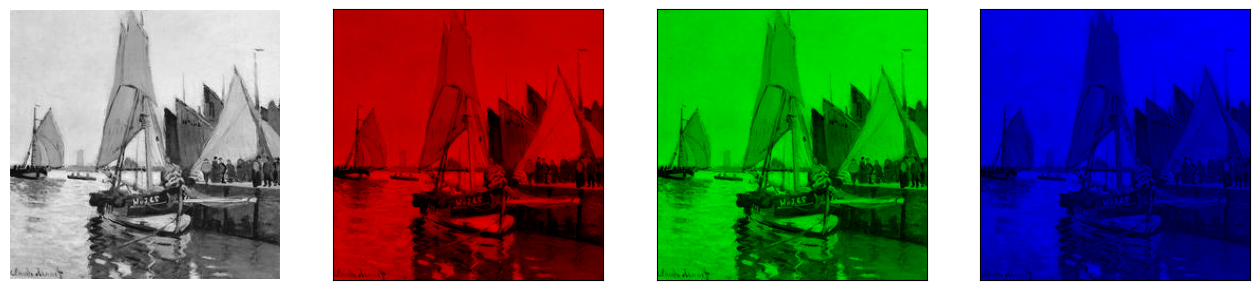

In [12]:
img_path = '/kaggle/input/gan-getting-started/monet_jpg/51db3fc011.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/1814cc6632.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/4995c04b1a.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

## 2.3 Grayscale Visualization
# <a id="2.3"></a>


In [13]:
def grayscale_visualization(image_path, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    tmp_img = np.full_like(img, 0)
    for i in range(3):
        tmp_img[:, :, i] = img.mean(axis=-1)
    plt.imshow(tmp_img)
    plt.axis('off')
    
    
    plt.show()

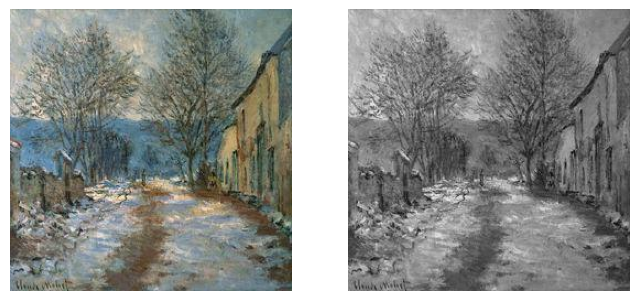

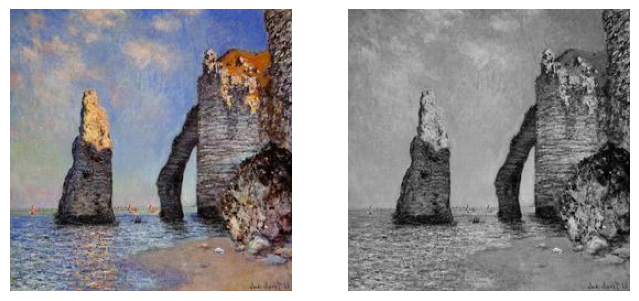

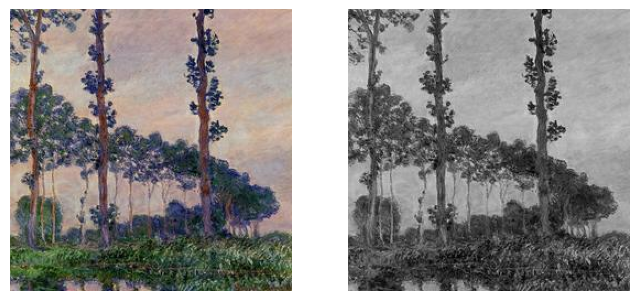

In [14]:
img_path = '/kaggle/input/gan-getting-started/monet_jpg/5c79cfe0b3.jpg'
grayscale_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/990ed28f62.jpg'
grayscale_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/fd63a333f1.jpg'
grayscale_visualization(img_path)

# <a id="3"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">DModel Architecture </p>   </span></font></center> 
# 3. DModel Architecture

## 3.1 Downsampling blocks

The downsampling components of the architecture employ convolutional layers to amplify the quantity of feature maps, concurrently diminishing the spatial dimensions of the 2D images.

In [15]:
class Downsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        norm=True,
        lrelu=True,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=not norm),
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        if lrelu is not None:
            self.block.append(nn.LeakyReLU(0.2, True) if lrelu else nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

In [16]:
class Upsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        output_padding=0,
        dropout=False,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size=kernel_size, stride=stride, 
                               padding=padding, output_padding=output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

## 3.2 ResNet generator

Like the U-Net, the ResNet generator is structured with both a downsampling and an upsampling pathway. However, it deviates from U-Net by omitting the extended skip connections that result from the concatenation of outputs. In the ResNet generator, the alternative is the utilization of residual blocks that bridge the two pathways. These blocks feature short skip connections, where the original input signal is directly summed to the output, thereby enhancing the flow of information and aiding in the training process.

In [17]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
                nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=False),
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=None),
        )
        
    def forward(self, x):
        return x + self.block(x)

## 3.3 U-Net Generator

The U-Net is a prevalent design for the CycleGAN generator, characterized by its U-shaped structure. It comprises a series of downsampling stages, succeeded by an equivalent number of upsampling stages. During the upsampling phase, the outputs from the upsampling and corresponding downsampling stages are concatenated in a symmetrical manner. This concatenation acts as a form of skip connection, which aids in the transmission of information throughout the network's depths and mitigates the effects of vanishing gradients.


In [18]:
class UNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8), # 512x16x16
            Downsampling(hid_channels*8, hid_channels*8), # 512x8x8
            Downsampling(hid_channels*8, hid_channels*8), # 512x4x4
            Downsampling(hid_channels*8, hid_channels*8), # 512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), # 512x1x1, instance norm does not work on 1x1
        )
        self.upsampling_path = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), # (512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), # (512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), # (256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), # (128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), # (64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)
    
class ResNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels, num_resblocks):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            Downsampling(in_channels, hid_channels,
                         kernel_size=7, stride=1, padding=0, lrelu=False), # 64x256x256
            Downsampling(hid_channels, hid_channels*2, kernel_size=3, lrelu=False), # 128x128x128
            Downsampling(hid_channels*2, hid_channels*4, kernel_size=3, lrelu=False), # 256x64x64
            *[ResBlock(hid_channels*4) for _ in range(num_resblocks)], # 256x64x64
            Upsampling(hid_channels*4, hid_channels*2, kernel_size=3, output_padding=1), # 128x128x128
            Upsampling(hid_channels*2, hid_channels, kernel_size=3, output_padding=1), # 64x256x256
            nn.ReflectionPad2d(3),
            nn.Conv2d(hid_channels, out_channels, kernel_size=7, stride=1, padding=0), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.model(x)
    
def get_gen(gen_name, hid_channels, num_resblocks, in_channels=3, out_channels=3):
    if gen_name == "unet":
        return UNetGenerator(hid_channels, in_channels, out_channels)
    elif gen_name == "resnet":
        return ResNetGenerator(hid_channels, in_channels, out_channels, num_resblocks)
    else:
        raise NotImplementedError(f"Generator name '{gen_name}' not recognized.")

In [19]:
class Discriminator(nn.Module):
    def __init__(self, hid_channels, in_channels=3):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), # 512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), # 1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

In [20]:
class ImageBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        if self.buffer_size > 0:
            # the current capacity of the buffer
            self.curr_cap = 0
            # initialize buffer as empty list
            self.buffer = []
    
    def __call__(self, imgs):
        # the buffer is not used
        if self.buffer_size == 0:
            return imgs
        
        return_imgs = []
        for img in imgs:
            img = img.unsqueeze(dim=0)
            
            # fill buffer to maximum capacity
            if self.curr_cap < self.buffer_size:
                self.curr_cap += 1
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                p = np.random.uniform(low=0., high=1.)
                
                # swap images between input and buffer with probability 0.5
                if p > 0.5:
                    idx = np.random.randint(low=0, high=self.buffer_size)
                    tmp = self.buffer[idx].clone()
                    self.buffer[idx] = img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs, dim=0)

## 3.4 CycleGAN
Once the structures for the generator and discriminator are established, we can proceed to construct the CycleGAN framework, which comprises a pair of generators and a pair of discriminators:

- A generator designed for converting photos into Monet-style paintings (referred to as gen_PM).
- A generator for the reverse process, turning Monet-style paintings back into photos (denoted as gen_MP).
- A discriminator specialized in discerning Monet paintings (known as disc_M).
- A discriminator for identifying real photos (referred to as disc_P).
For the training of the model, we employ the Adam optimizer. To refine the parameters, it is essential to establish the appropriate loss functions:

Discriminator Loss: The loss is calculated by comparing the discriminator's output for actual images against a target matrix filled with ones, using the mean squared error. Conversely, for synthetic images, the comparison is against a target matrix of zeros. This implies that the ideal discriminator should produce an output matrix of ones for genuine images and zeros for the counterfeit ones to minimize the loss.

Generator Loss: This encompasses three distinct components:

- **Adversarial Loss**: Synthetic images are presented to the discriminator, and the output is compared with a target matrix of ones, also using the mean squared error. The generator aims to minimize this loss by convincing the discriminator that the fabricated images are authentic.
- **Identity Loss**: When a Monet painting is processed by the photo-to-Monet generator, the expectation is to retrieve the original painting, indicating no transformation is necessary. The same principle is applied when photos are processed by the Monet-to-photo generator. The identity loss measures the pixel-wise difference between the input and the generated image using the L1 norm, promoting the preservation of the original identity.
- **Cycle Loss**: If a Monet painting is input into the Monet-to-photo generator and the resulting photo is then fed back into the photo-to-Monet generator, the cycle should ideally conclude with the restoration of the original painting. The same principle applies to photos processed through both generators. The cycle loss, measured by the L1 norm, quantifies the discrepancy between the original and the reconstructed image, ensuring that information is conserved throughout the translation cycle.

**Model Configs**

In [21]:
MODEL_CONFIG = {
    # the type of generator, and the number of residual blocks if ResNet generator is used
    "gen_name": "unet", # types: 'unet', 'resnet'
    "num_resblocks": 6,
    # the number of filters in the first layer for the generators and discriminators
    "hid_channels": 64,
    # using DeepSpeed's FusedAdam (currently GPU only) is slightly faster
    "optimizer": ds.ops.adam.FusedAdam if torch.cuda.is_available() else torch.optim.Adam,
    # the learning rate and beta parameters for the Adam optimizer
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    # the weights used in the identity loss and cycle loss
    "lambda_idt": 0.5,
    "lambda_cycle": (10, 10), # (MPM direction, PMP direction)
    # the size of the buffer that stores previously generated images
    "buffer_size": 100,
    # the number of epochs for training
    "num_epochs": 18 if not DEBUG else 2,
    # the number of epochs before starting the learning rate decay
    "decay_epochs": 18 if not DEBUG else 1,
}

In [22]:
class CycleGAN(L.LightningModule):
    def __init__(
        self,
        gen_name,
        num_resblocks,
        hid_channels,
        optimizer,
        lr,
        betas,
        lambda_idt,
        lambda_cycle,
        buffer_size,
        num_epochs,
        decay_epochs,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["optimizer"])
        self.optimizer = optimizer
        self.automatic_optimization = False
        
        # define generators and discriminators
        self.gen_PM = get_gen(gen_name, hid_channels, num_resblocks)
        self.gen_MP = get_gen(gen_name, hid_channels, num_resblocks)
        self.disc_M = Discriminator(hid_channels)
        self.disc_P = Discriminator(hid_channels)
        
        # initialize buffers to store fake images
        self.buffer_fake_M = ImageBuffer(buffer_size)
        self.buffer_fake_P = ImageBuffer(buffer_size)
        
    def forward(self, img):
        return self.gen_PM(img)   
            
    def init_weights(self):
        def init_fn(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
        
        for net in [self.gen_PM, self.gen_MP, self.disc_M, self.disc_P]:
            net.apply(init_fn)
        
    def setup(self, stage):
        if stage == "fit":
            self.init_weights()
            print("Model initialized.")
            
    def get_lr_scheduler(self, optimizer):
        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)
        
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    
    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.gen_PM.parameters()) + list(self.gen_MP.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.disc_M.parameters()) + list(self.disc_P.parameters()),
            **opt_config,
        )
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers
        
    def adv_criterion(self, y_hat, y):
        return F.mse_loss(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def get_adv_loss(self, fake, disc):
        fake_hat = disc(fake)
        real_labels = torch.ones_like(fake_hat)
        adv_loss = self.adv_criterion(fake_hat, real_labels)
        return adv_loss
    
    def get_idt_loss(self, real, idt, lambda_cycle):
        idt_loss = self.recon_criterion(idt, real)
        return self.hparams.lambda_idt * lambda_cycle * idt_loss
    
    def get_cycle_loss(self, real, recon, lambda_cycle):
        cycle_loss = self.recon_criterion(recon, real)
        return lambda_cycle * cycle_loss
    
    def get_gen_loss(self):
        # calculate adversarial loss
        adv_loss_PM = self.get_adv_loss(self.fake_M, self.disc_M)
        adv_loss_MP = self.get_adv_loss(self.fake_P, self.disc_P)
        total_adv_loss = adv_loss_PM + adv_loss_MP
        
        # calculate identity loss
        lambda_cycle = self.hparams.lambda_cycle
        idt_loss_MM = self.get_idt_loss(self.real_M, self.idt_M, lambda_cycle[0])
        idt_loss_PP = self.get_idt_loss(self.real_P, self.idt_P, lambda_cycle[1])
        total_idt_loss = idt_loss_MM + idt_loss_PP
        
        # calculate cycle loss
        cycle_loss_MPM = self.get_cycle_loss(self.real_M, self.recon_M, lambda_cycle[0])
        cycle_loss_PMP = self.get_cycle_loss(self.real_P, self.recon_P, lambda_cycle[1])
        total_cycle_loss = cycle_loss_MPM + cycle_loss_PMP
        
        # combine losses
        gen_loss = total_adv_loss + total_idt_loss + total_cycle_loss
        return gen_loss
    
    def get_disc_loss(self, real, fake, disc):
        # calculate loss on real images
        real_hat = disc(real)
        real_labels = torch.ones_like(real_hat)
        real_loss = self.adv_criterion(real_hat, real_labels)
        
        # calculate loss on fake images
        fake_hat = disc(fake.detach())
        fake_labels = torch.zeros_like(fake_hat)
        fake_loss = self.adv_criterion(fake_hat, fake_labels)
        
        # combine losses
        disc_loss = (fake_loss + real_loss) * 0.5
        return disc_loss
    
    def get_disc_loss_M(self):
        fake_M = self.buffer_fake_M(self.fake_M)
        return self.get_disc_loss(self.real_M, fake_M, self.disc_M)
    
    def get_disc_loss_P(self):
        fake_P = self.buffer_fake_P(self.fake_P)
        return self.get_disc_loss(self.real_P, fake_P, self.disc_P)
    
    def training_step(self, batch, batch_idx):
        self.real_M = batch["monet"]
        self.real_P = batch["photo"]
        opt_gen, opt_disc = self.optimizers()

        # generate fake images
        self.fake_M = self.gen_PM(self.real_P)
        self.fake_P = self.gen_MP(self.real_M)
        
        # generate identity images
        self.idt_M = self.gen_PM(self.real_M)
        self.idt_P = self.gen_MP(self.real_P)
        
        # reconstruct images
        self.recon_M = self.gen_PM(self.fake_P)
        self.recon_P = self.gen_MP(self.fake_M)
    
        # train generators
        self.toggle_optimizer(opt_gen)
        gen_loss = self.get_gen_loss()        
        opt_gen.zero_grad()
        self.manual_backward(gen_loss)
        opt_gen.step()
        self.untoggle_optimizer(opt_gen)
        
        # train discriminators
        self.toggle_optimizer(opt_disc)
        disc_loss_M = self.get_disc_loss_M()
        disc_loss_P = self.get_disc_loss_P()
        opt_disc.zero_grad()
        self.manual_backward(disc_loss_M)
        self.manual_backward(disc_loss_P)
        opt_disc.step()
        self.untoggle_optimizer(opt_disc)
        
        # record training losses
        metrics = {
            "gen_loss": gen_loss,
            "disc_loss_M": disc_loss_M,
            "disc_loss_P": disc_loss_P,
        }
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        
    def validation_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "validate")
    
    def test_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "test")
        
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def display_results(self, batch, batch_idx, stage):
        real_P = batch
        fake_M = self(real_P)
        
        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: Photo-to-Monet Translation"
        else:
            title = f"Sample {batch_idx+1}: Photo-to-Monet Translation"

        show_img(
            torch.cat([real_P, fake_M], dim=0),
            nrow=len(real_P),
            title=title,
        )
    
    def on_train_epoch_start(self):
        # record learning rates
        curr_lr = self.lr_schedulers()[0].get_last_lr()[0]
        self.log("lr", curr_lr, on_step=False, on_epoch=True, prog_bar=True)
        
    def on_train_epoch_end(self):
        # update learning rates
        for sch in self.lr_schedulers():
            sch.step()
        
        # print current state of epoch
        logged_values = self.trainer.progress_bar_metrics
        print(
            f"Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in logged_values.items()],
            sep=" - ",
        )
        
    def on_train_end(self):
        print("Training ended.")
        
    def on_predict_epoch_end(self):
        predictions = self.trainer.predict_loop.predictions
        num_batches = len(predictions)
        batch_size = predictions[0].shape[0]
        last_batch_diff = batch_size - predictions[-1].shape[0]
        print(f"Number of images generated: {num_batches*batch_size-last_batch_diff}.")

**Training**

In [33]:
TRAIN_CONFIG = {
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    
    # train on 16-bit precision
    "precision": "16-mixed" if torch.cuda.is_available() else 32,
    
    # train on single GPU
    "devices": 1,
    
    # save checkpoint only for last epoch by default
    "enable_checkpointing": True,
    
    # disable logging for simplicity
    "logger": False,
    
    # the number of epochs for training (we limit the number of train/predict batches during debugging)
    "max_epochs": MODEL_CONFIG["num_epochs"],
    "limit_train_batches": 1.0 if not DEBUG else 2,
    "limit_predict_batches": 1.0 if not DEBUG else 5,
    
    # the maximum amount of time for training, in case we exceed run-time of 5 hours
    "max_time": {"hours": 4, "minutes": 55},
    
    # use a small subset of photos for validation/testing (we limit here for flexibility)
    "limit_val_batches": 1,
    "limit_test_batches": 5,
    
    # disable sanity check before starting the training routine
    "num_sanity_val_steps": 0,
    
    # the frequency to visualize the progress of adding Monet style
    "check_val_every_n_epoch": 6 if not DEBUG else 1,
}

Model initialized.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - lr: 0.00020 - gen_loss: 6.15437 - disc_loss_M: 0.15772 - disc_loss_P: 0.14705
Epoch 2 - lr: 0.00020 - gen_loss: 3.60392 - disc_loss_M: 0.15676 - disc_loss_P: 0.13666
Epoch 3 - lr: 0.00020 - gen_loss: 3.04418 - disc_loss_M: 0.18352 - disc_loss_P: 0.15310
Epoch 4 - lr: 0.00020 - gen_loss: 2.82357 - disc_loss_M: 0.18373 - disc_loss_P: 0.16468
Epoch 5 - lr: 0.00020 - gen_loss: 2.77729 - disc_loss_M: 0.17778 - disc_loss_P: 0.16446


Validation: |          | 0/? [00:00<?, ?it/s]

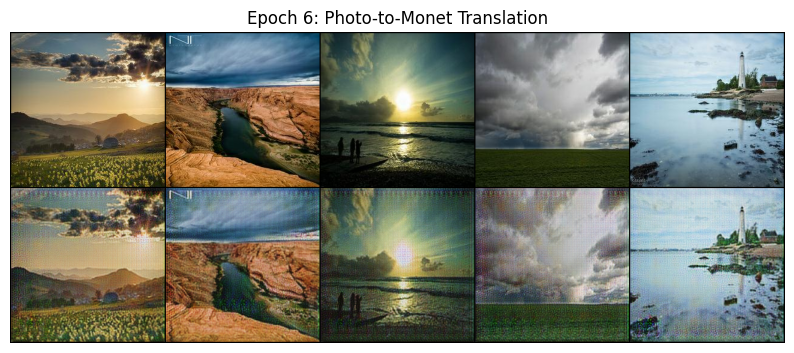

Epoch 6 - lr: 0.00020 - gen_loss: 2.73782 - disc_loss_M: 0.17781 - disc_loss_P: 0.16184
Epoch 7 - lr: 0.00020 - gen_loss: 2.65670 - disc_loss_M: 0.17939 - disc_loss_P: 0.16769
Epoch 8 - lr: 0.00020 - gen_loss: 2.58592 - disc_loss_M: 0.18081 - disc_loss_P: 0.16518
Epoch 9 - lr: 0.00020 - gen_loss: 2.49989 - disc_loss_M: 0.18038 - disc_loss_P: 0.16800
Epoch 10 - lr: 0.00020 - gen_loss: 2.45826 - disc_loss_M: 0.17907 - disc_loss_P: 0.16874
Epoch 11 - lr: 0.00020 - gen_loss: 2.39184 - disc_loss_M: 0.18026 - disc_loss_P: 0.16775


Validation: |          | 0/? [00:00<?, ?it/s]

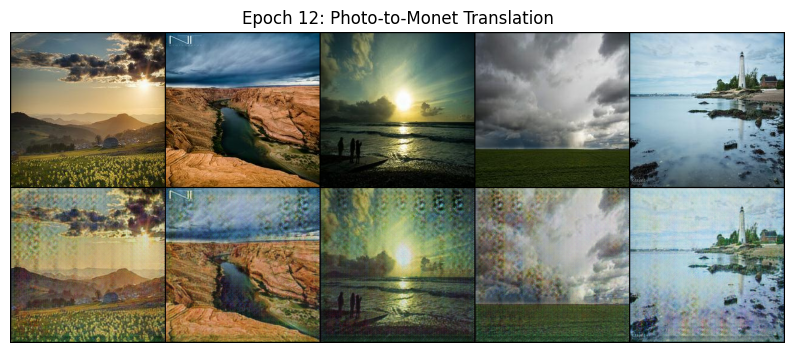

Epoch 12 - lr: 0.00020 - gen_loss: 2.33633 - disc_loss_M: 0.18247 - disc_loss_P: 0.16589
Epoch 13 - lr: 0.00020 - gen_loss: 2.28326 - disc_loss_M: 0.18475 - disc_loss_P: 0.16688
Epoch 14 - lr: 0.00020 - gen_loss: 2.26424 - disc_loss_M: 0.18150 - disc_loss_P: 0.17134
Epoch 15 - lr: 0.00020 - gen_loss: 2.20971 - disc_loss_M: 0.18251 - disc_loss_P: 0.16855
Epoch 16 - lr: 0.00020 - gen_loss: 2.18669 - disc_loss_M: 0.18236 - disc_loss_P: 0.17205
Epoch 17 - lr: 0.00020 - gen_loss: 2.19197 - disc_loss_M: 0.27796 - disc_loss_P: 0.21208


Validation: |          | 0/? [00:00<?, ?it/s]

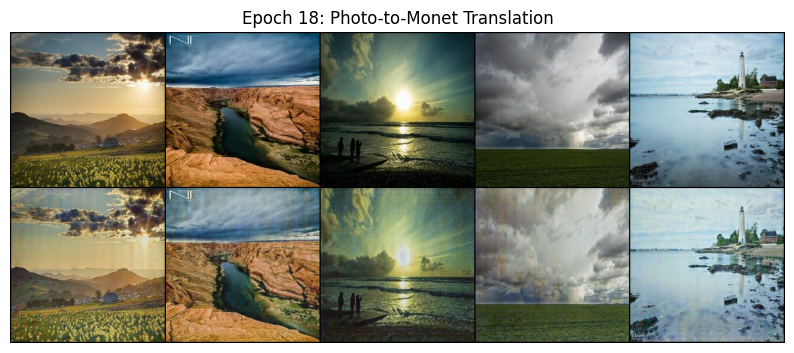

Epoch 18 - lr: 0.00020 - gen_loss: 1.71651 - disc_loss_M: 0.23274 - disc_loss_P: 0.23079
Training ended.


In [34]:
dm = CustomDataModule(**DM_CONFIG)
model = CycleGAN(**MODEL_CONFIG)
trainer = L.Trainer(**TRAIN_CONFIG)
trainer.fit(model, datamodule=dm)

# <a id="4"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Results and Analysis </p>   </span></font></center> 
# 4. Results and Analysis

Testing: |          | 0/? [00:00<?, ?it/s]

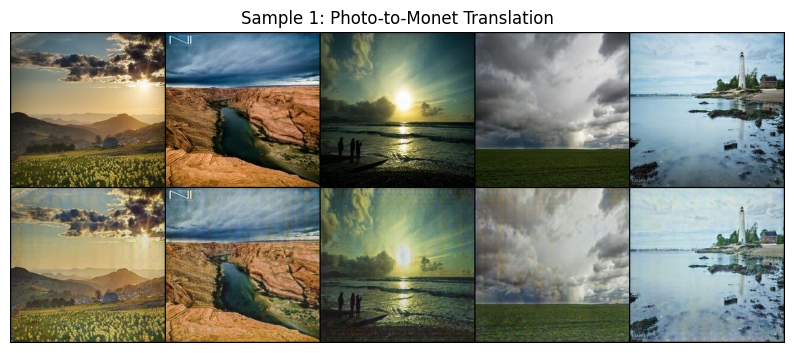

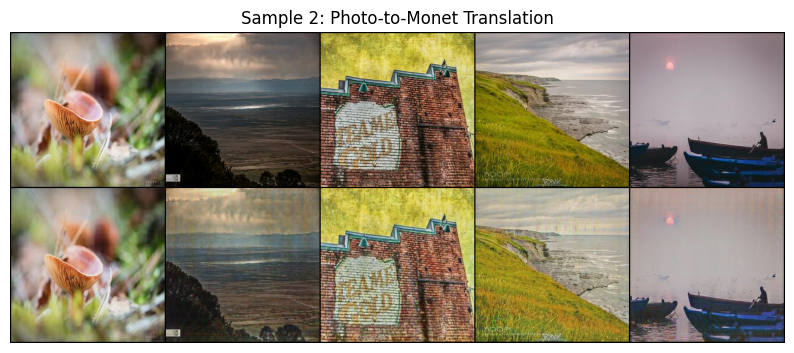

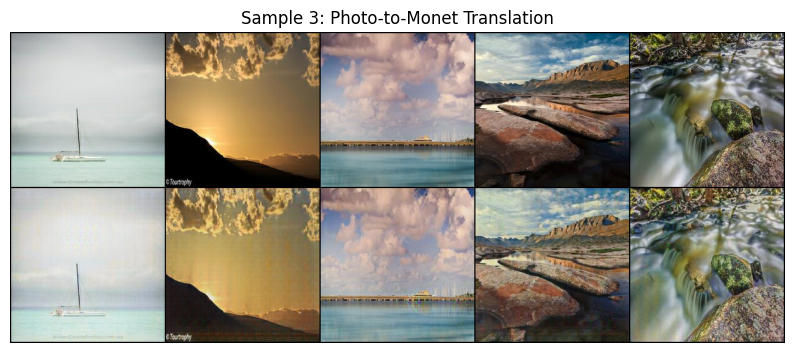

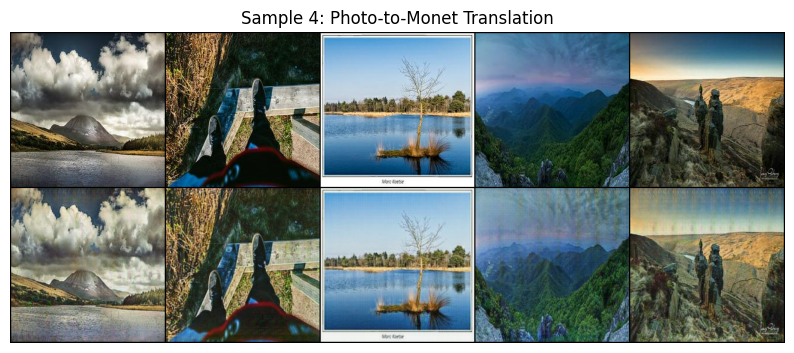

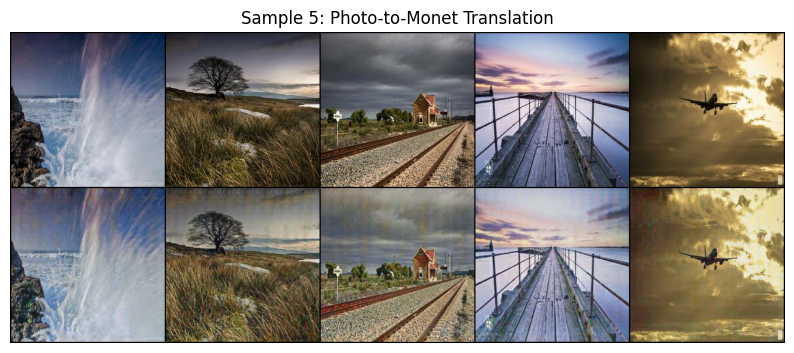

In [35]:
_ = trainer.test(model, datamodule=dm)

In [36]:
predictions = trainer.predict(model, datamodule=dm)

Predicting: |          | 0/? [00:00<?, ?it/s]

Number of images generated: 7038.


In [37]:
os.makedirs("../images", exist_ok=True)
idx = 0
for tensor in predictions:
    for monet in tensor:
        save_image(
            monet.float().squeeze() * 0.5 + 0.5, 
            fp=f"../images/{idx}.jpg",
        )
        idx += 1

shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/images")

'/kaggle/working/images.zip'

# <a id="5"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Conclusion </p>   </span></font></center> 
# 5. Conclusion

CycleGAN represents a significant advancement in the field of image-to-image translation, enabling high-quality results without the need for paired training data. By leveraging a dual GAN architecture and cycle-consistency loss, CycleGAN effectively addresses the challenge of unpaired image translation, facilitating applications across diverse domains such as style transfer, image enhancement, and cross-domain image generation.

However, despite its impressive capabilities, CycleGAN is not without its limitations. One major issue is the instability encountered during the training process, often leading to mode collapse where the model fails to produce diverse outputs. Additionally, the quality of the generated images can be inconsistent, and the training process is computationally intensive, requiring significant resources to achieve optimal performance.

To address these challenges, several improvements can be considered:

1. **Enhanced Loss Functions**: Incorporating more sophisticated loss functions, such as perceptual loss or feature matching loss, can help improve the quality and consistency of the generated images.

2. **Architecture Innovations**: Exploring advanced network architectures, like attention mechanisms or multi-scale discriminators, can lead to better feature extraction and more realistic outputs.

3. **Regularization and Data Augmentation**: Employing techniques like dropout, spectral normalization, and extensive data augmentation can stabilize the training process and enhance model robustness.

4. **Progressive Training**: Implementing a progressive training schedule, where the model gradually learns to generate higher resolution images, can mitigate issues related to training instability and improve the final output quality.

In conclusion, while CycleGAN has significantly expanded the capabilities of unpaired image translation, the pursuit of improved stability, efficiency, and image quality remains an active area of research. Future work will likely focus on refining these aspects, unlocking new potentials for CycleGAN and its variants in various real-world applications.